In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import Set
from pathlib import Path



warnings.filterwarnings("ignore")

<ipython-input-1-ca397ef93819>:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Set


**Vorschlag Zielwert ZQ Synergy**

$PE(GFZ)= min( 1,63*(\frac{35.2}{GFZ+0,15}-27.3) ; 100) $     $[kWh_{PE}/m²_{BGF}a]$

In [2]:
# ZQ Austria Vorschlag

GFZ = np.linspace(0.0, 8, 800) #min, max, steps
def target(
        GFZ=GFZ,
        fPE=1.63, # OIB 2019 Jahresmittel
        A=35.2,
        dx=0.15,
        EUI=27.3,
        cutoff=100,
        scale=1
) -> pd.DataFrame:
    curve = (fPE * (A/(dx + GFZ) - EUI )) * scale
    return np.minimum(curve, cutoff) if cutoff else curve

target()


array([ 1.00000000e+02,  1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  9.88288849e+01,  9.53314835e+01,  9.20006993e+01,
        8.88249029e+01,  8.57935224e+01,  8.28969261e+01,  8.01263201e+01,
        7.74736593e+01,  7.49315692e+01,  7.24932777e+01,  7.01525543e+01,
        6.79036578e+01,  6.57412886e+01,  6.36605470e+01,  6.16568967e+01,
        5.97261313e+01,  5.78643449e+01,  5.60679058e+01,  5.43334329e+01,
        5.26577744e+01,  5.10379886e+01,  4.94713269e+01,  4.79552180e+01,
        4.64872538e+01,  4.50651770e+01,  4.36868690e+01,  4.23503398e+01,
        4.10537181e+01,  

In [3]:
PEQ_alfa = pd.DataFrame({
    "Positive Energy Balance":np.zeros(len(GFZ)),
    "ZQ1 Endbericht":target(GFZ, A=37, dx=0.085,EUI=29.14, cutoff=None),
    "ZQ1 Formel (auf NGF bezogen)":
        target(GFZ, A=37, dx=0.085,EUI=29.14, fPE=1.63*0.8, cutoff=None),
    "Vorschlag ZQ Synergy": target(GFZ),
}, index=GFZ)


In [4]:
def plot_context_factor(ax, df, ylims=(-75,150), xlims=(0,8), no_legend=False):
    if no_legend: # names with leading underscore dont show
        df.columns = ["_" + col for col in df.columns]
    df.plot(ax=ax, linestyle="solid", linewidth=1, )
    ax.set_ylim(*ylims); ax.set_xlim(*xlims)
    ax.set_ylabel("PE-Balance $[{kWh/m²_{BGF}a}]$")
    ax.set_xlabel("Floor space index")
    ax.grid()

    #ax.legend(title='', bbox_to_anchor=(1, 1), loc='upper left')

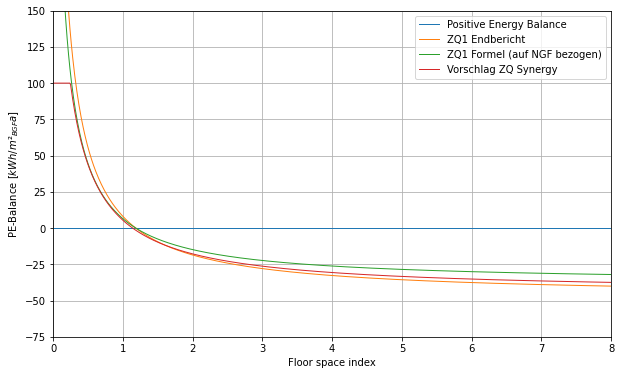

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
plot_context_factor(ax, df=PEQ_alfa)

Specify excel path

In [6]:
path = Path(r"C:\Users\Simon Schneider\Nextcloud\EE\1_Forschung\2_Laufend\Plusenergie-Campus Energybase 2.0 (Sdz 9)\4_Quartier\PEExcel_final\PEC Varianten.xlsx")

df = pd.read_excel(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Columns: 377 entries, Name to auf Straßen/Gehwegen
dtypes: bool(13), float64(250), int64(93), object(21)
memory usage: 2.2+ MB


Identify the required columns

In [7]:
df.columns

Index(['Name', 'Quartier', 'Forschungsprojekt', 'Land', 'Stadt', 'Variante',
       'Beschreibung', 'Mikroquartier', 'Generation', 'Gebäudehülle',
       ...
       'GFZ', 'Primärenergiesaldo ohne Dichteausgleich', 'PE-Saldo Ziel NGF',
       'PE-Anforderung erreicht? Werte inkl. Dichtebonus',
       'PE-Saldo Ziel BGF default (NGF/BGF=0,8)',
       'PE-Saldo Ziel BGF real (NGF/BGF=0,85)', 'Heizenergie [MWh/a]',
       'Kühlenergie [MWh/a]', 'Umweltenergiepotential auf Grundstück [MWh/a]',
       'auf Straßen/Gehwegen'],
      dtype='object', length=377)

In [8]:
available = set(df.columns)

PEB_varname = "Primärenergiesaldo ohne Dichteausgleich"
PEB_Zielwert = "PE-Saldo Ziel BGF real (NGF/BGF=0,85)"
GFZ = "GFZ"
required = {
    "Name",

    "Mikroquartier",
    "Gebäudehülle",
    "Lüftung mit WRG",
    "PV",
    "JAZ",
    "Reduktion Nutzerstrom",
    "ecars",
    "WPS",
    "Klima",

    GFZ,
    PEB_varname,
    PEB_Zielwert,
    'Heizenergie [MWh/a]',
    'Kühlenergie [MWh/a]',
    'Umweltenergiepotential auf Grundstück [MWh/a]',

}

print("missing columns:\n", required - available)

missing columns:
 set()


In [9]:
for c in df.columns:
    if "PE" in c:
        print(c)

PEBedarf [kWh/m²NGFa]
CO2,PE Profil
PEBedarf [kWh/m²NGFa].1
PEExport [kWh/m²NGFa]
PESaldo [kWh/m²NGFa]
PEBedarf [kWh/m²NGFa].2
PEExport [kWh/m²NGFa].1
PESaldo [kWh/m²NGFa].1
PEBedarf [kWh/m²NGFa].3
PEExport [kWh/m²NGFa].2
PESaldo [kWh/m²NGFa].2
PE-Saldo Ziel NGF [kWh/m²NGFa]
PE-Anforderung erreicht? Werte inkl. Dichtebonus [kWh/m²NGFa]
PE-Saldo Ziel BGF default (NGF/BGF=0,8) [kWh/m²BGFa]
PE-Saldo Ziel BGF real (NGF/BGF=0,85) [kWh/m²BGFa]
PEBedarf [kWh/m²NGFa].4
PEExport [kWh/m²NGFa].3
PESaldo [kWh/m²NGFa].3
PE-Saldo Ziel NGF
PE-Anforderung erreicht? Werte inkl. Dichtebonus
PE-Saldo Ziel BGF default (NGF/BGF=0,8)
PE-Saldo Ziel BGF real (NGF/BGF=0,85)


<AxesSubplot:xlabel='Floor space index', ylabel='PE-Balance $[{kWh/m²_{BGF}a}]$'>

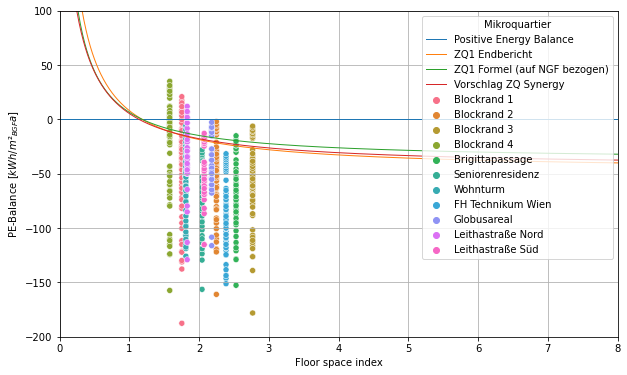

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
plot_context_factor(ax, df=PEQ_alfa, ylims=(-200,100))
sns.set_palette("Set2") #"Reds"
sns.scatterplot(ax=ax,
                x=GFZ,
                y=PEB_varname,
                hue="Mikroquartier",
                data=df)

In [11]:
subplot_columns = [
    "Mikroquartier",
    "Gebäudehülle",
    "Lüftung mit WRG",
    "PV",
    "JAZ",
    "Reduktion Nutzerstrom",
    "ecars",
    "WPS",
    "Klima"]

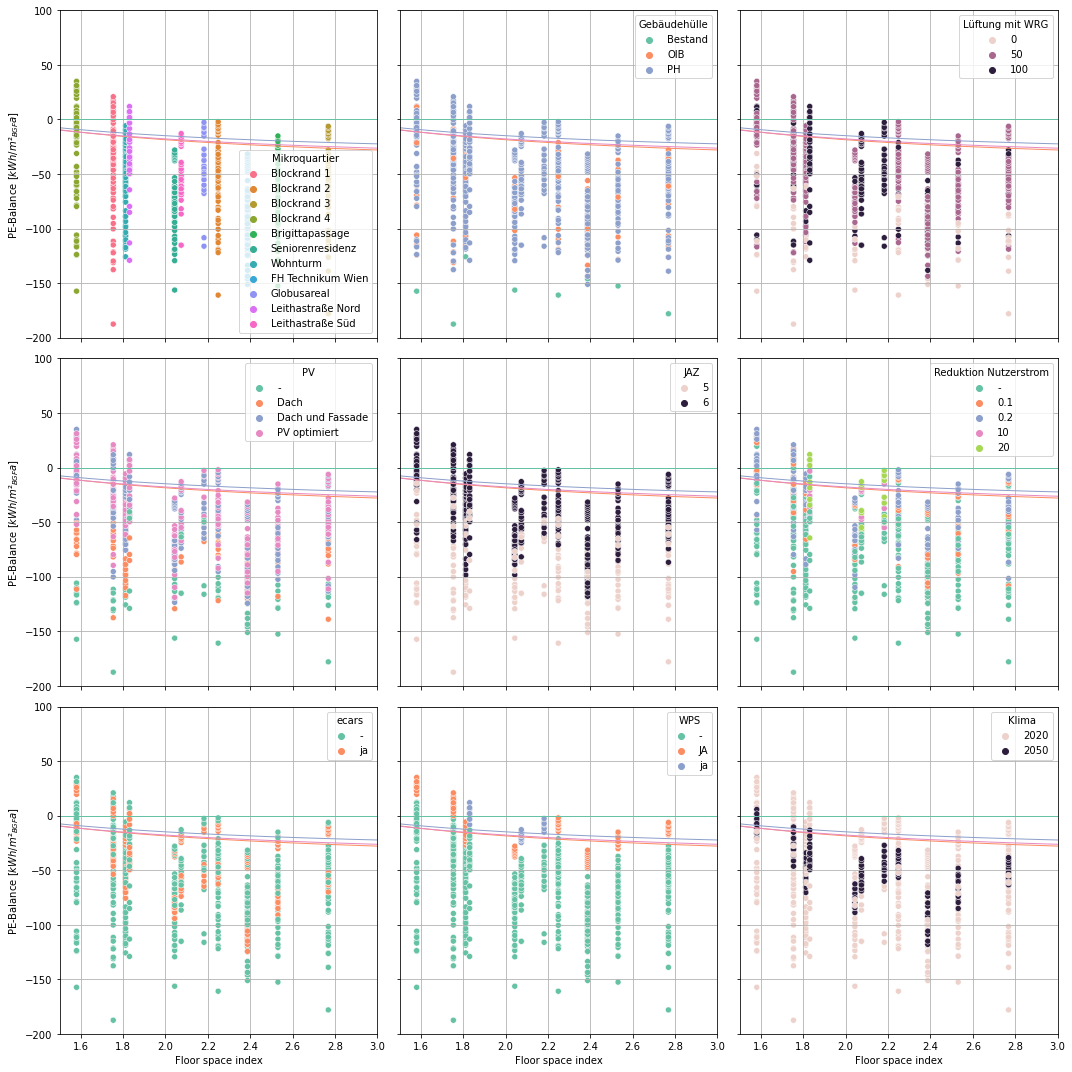

In [12]:
fig, axes = plt.subplots(3,3, figsize=(15,15), sharex=True, sharey=True)
for ax, category in zip(axes.flatten(), subplot_columns):
    plot_context_factor(ax,
                        df=PEQ_alfa,
                        ylims=(-200,100),
                        xlims=(1.5,3),
                        no_legend=True
                        )
    sns.scatterplot(ax=ax,
                    x=GFZ,
                    y=PEB_varname,
                    hue=category,
                    data=df)
plt.tight_layout()

In [13]:
dfmin = df[required]
dfmin.columns


Index(['Klima', 'ecars', 'Gebäudehülle', 'Heizenergie [MWh/a]',
       'Umweltenergiepotential auf Grundstück [MWh/a]', 'PV', 'WPS', 'JAZ',
       'Mikroquartier', 'GFZ', 'Reduktion Nutzerstrom',
       'PE-Saldo Ziel BGF real (NGF/BGF=0,85)',
       'Primärenergiesaldo ohne Dichteausgleich', 'Lüftung mit WRG',
       'Kühlenergie [MWh/a]', 'Name'],
      dtype='object')

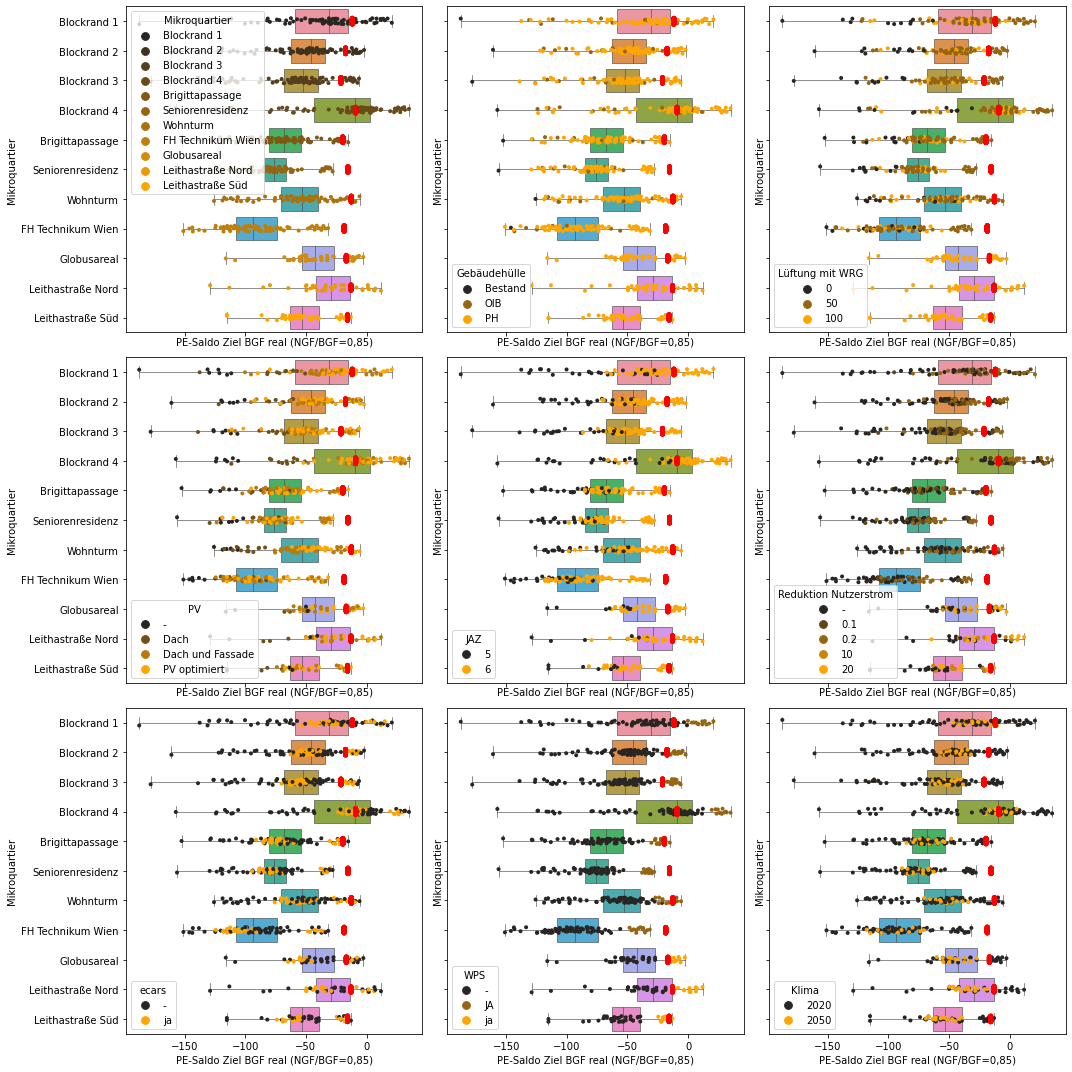

In [14]:
fig, axes = plt.subplots(3,3, figsize=(15,15), sharex=True, sharey=True)
for ax, category in zip(axes.flatten(), subplot_columns):
    sns.boxplot(ax=ax, data=dfmin,
                x=PEB_varname, y="Mikroquartier",
                whis=[0, 100], width=.8, linewidth=0.6
                )

    sns.stripplot(ax=ax, x=PEB_varname, y="Mikroquartier",
              data=dfmin, hue=category, color="orange",
              size=4, linewidth=0)

    sns.stripplot(ax=ax, x=PEB_Zielwert, y="Mikroquartier",
              data=dfmin, color="red",
              size=5, linewidth=0)
plt.tight_layout()

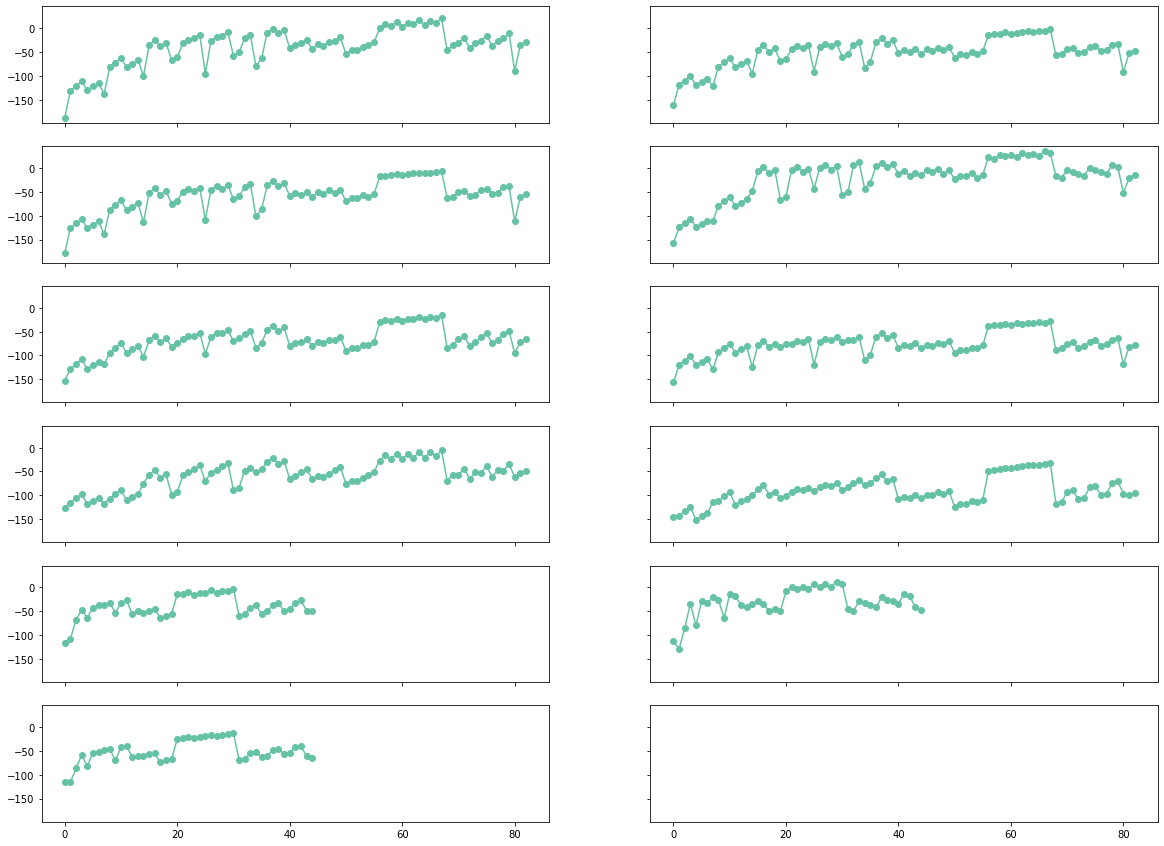

In [15]:
fig, axes = plt.subplots(6,2, figsize=(20,15), sharex=True, sharey=True)
for ax, mqs in zip(axes.flatten(), dfmin.Mikroquartier.unique()):
    ax.plot(np.arange(len(dfmin[dfmin.Mikroquartier==mqs])), PEB_varname,
    data=dfmin[dfmin.Mikroquartier==mqs], linestyle='-', marker='o')


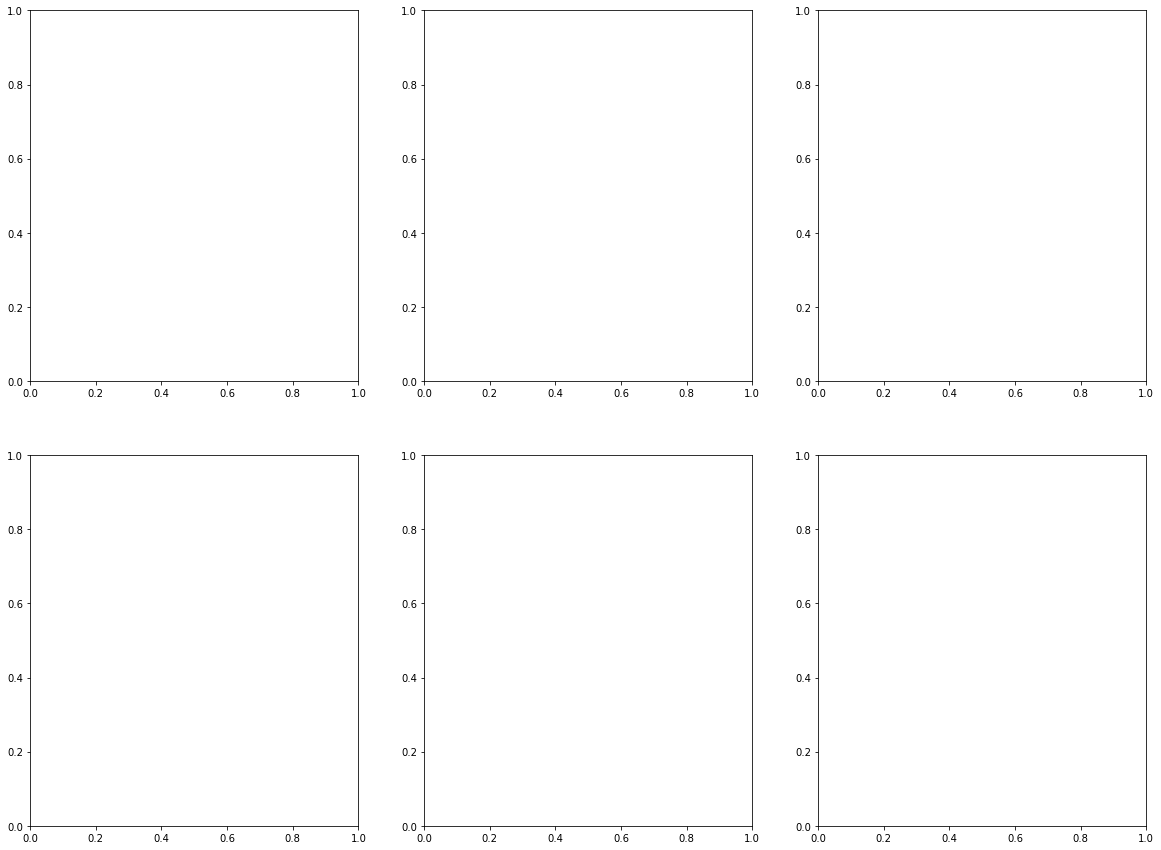

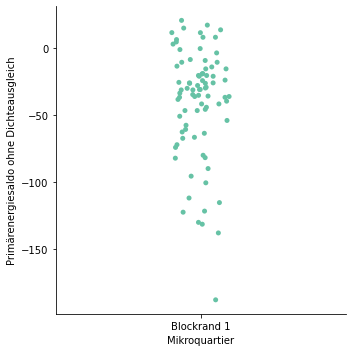

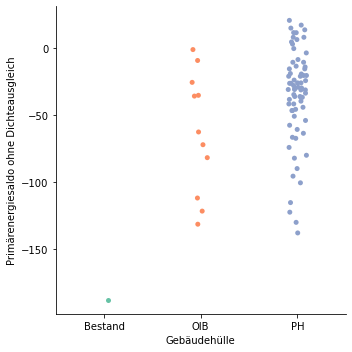

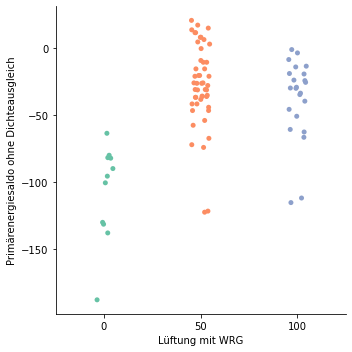

In [16]:
b1 = dfmin[dfmin.Mikroquartier=="Blockrand 1"]
mq_count = 2 #dfmin.Mikroquartier.unique()
cat_count = len(subplot_columns[:3])

fig, axes = plt.subplots(mq_count,cat_count, figsize=(20,15))
for axcol, cat in enumerate(subplot_columns[:3]):
    sns.catplot(ax=axes[0, axcol],
                x=cat,
                y=PEB_varname,
                order=b1[cat].unique(),
                data=b1)

In [17]:
test

NameError: name 'test' is not defined